<a href="https://colab.research.google.com/github/nechitacarina/Fake-News-Classification/blob/main/Fake_News_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##Imports

In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import zipfile
from collections import Counter

from sklearn.metrics import classification_report,confusion_matrix, accuracy_score
from sklearn.model_selection import train_test_split

import keras
import tensorflow as tf
from keras.preprocessing import text, sequence
from keras.models import Sequential
from keras.layers import Dense,Embedding,LSTM,Dropout
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

import re
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize, sent_tokenize
from sklearn.feature_extraction.text import TfidfVectorizer

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


##Open and Extract the Dataset


In [ ]:
from google.colab import drive
drive.mount('/content/drive')
path_file_zip = '/content/drive/My Drive/Dataset/archive.zip'
with zipfile.ZipFile(path_file_zip, 'r') as zip_file:
    zip_file.extractall('/content')

Mounted at /content/drive


In [ ]:
true_news = pd.read_csv('/content/True.csv')
fake_news = pd.read_csv('/content/Fake.csv')

In [ ]:
true_news.head()

,title,text,subject,date
0,"As U.S. budget fight looms, Republicans flip t...",WASHINGTON (Reuters) - The head of a conservat...,politicsNews,"December 31, 2017"
1,U.S. military to accept transgender recruits o...,WASHINGTON (Reuters) - Transgender people will...,politicsNews,"December 29, 2017"
2,Senior U.S. Republican senator: 'Let Mr. Muell...,WASHINGTON (Reuters) - The special counsel inv...,politicsNews,"December 31, 2017"
3,FBI Russia probe helped by Australian diplomat...,WASHINGTON (Reuters) - Trump campaign adviser ...,politicsNews,"December 30, 2017"
4,Trump wants Postal Service to charge 'much mor...,SEATTLE/WASHINGTON (Reuters) - President Donal...,politicsNews,"December 29, 2017"


In [ ]:
fake_news.head()

,title,text,subject,date
0,Donald Trump Sends Out Embarrassing New Year’...,Donald Trump just couldn t wish all Americans ...,News,"December 31, 2017"
1,Drunk Bragging Trump Staffer Started Russian ...,House Intelligence Committee Chairman Devin Nu...,News,"December 31, 2017"
2,Sheriff David Clarke Becomes An Internet Joke...,"On Friday, it was revealed that former Milwauk...",News,"December 30, 2017"
3,Trump Is So Obsessed He Even Has Obama’s Name...,"On Christmas day, Donald Trump announced that ...",News,"December 29, 2017"
4,Pope Francis Just Called Out Donald Trump Dur...,Pope Francis used his annual Christmas Day mes...,News,"December 25, 2017"


In [ ]:
true_news.info()
fake_news.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21417 entries, 0 to 21416
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   title    21417 non-null  object
 1   text     21417 non-null  object
 2   subject  21417 non-null  object
 3   date     21417 non-null  object
dtypes: object(4)
memory usage: 669.4+ KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23481 entries, 0 to 23480
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   title    23481 non-null  object
 1   text     23481 non-null  object
 2   subject  23481 non-null  object
 3   date     23481 non-null  object
dtypes: object(4)
memory usage: 733.9+ KB


##Exploring and Cleaning the Dataset

In [ ]:
true_news['class'] = 1
fake_news['class'] = 0
news = pd.concat([true_news, fake_news])
news.shape

(44898, 5)

In [ ]:
news.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 44898 entries, 0 to 23480
Data columns (total 5 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   title    44898 non-null  object
 1   text     44898 non-null  object
 2   subject  44898 non-null  object
 3   date     44898 non-null  object
 4   class    44898 non-null  int64 
dtypes: int64(1), object(4)
memory usage: 2.1+ MB


In [ ]:
news['class'].value_counts()

0    23481
1    21417
Name: class, dtype: int64

[Text(0.5, 1.0, 'Class Frequency')]

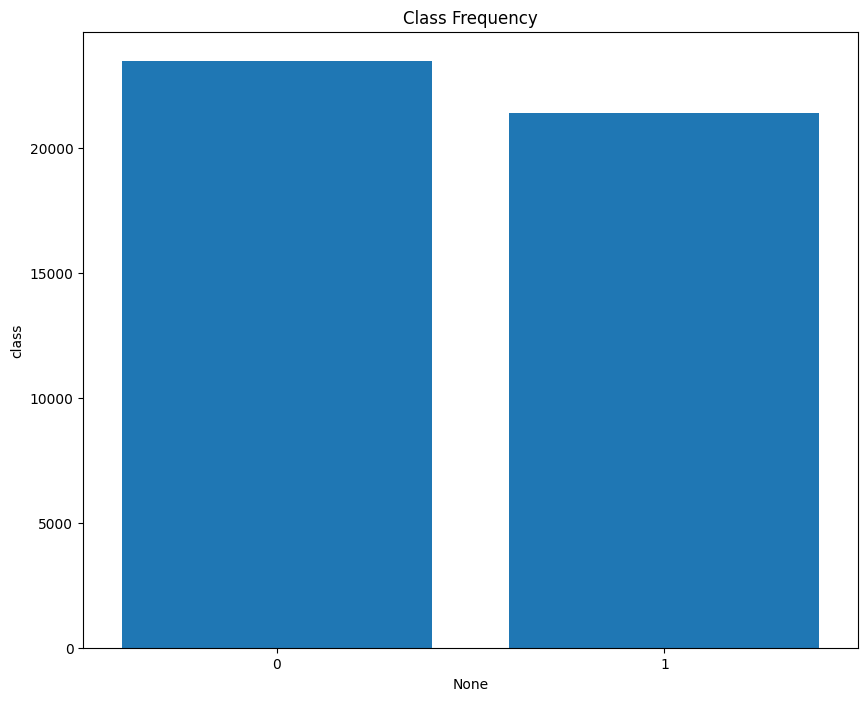

In [ ]:
plt.figure(figsize = [10, 8], clear = True, facecolor = 'white')
sns.barplot(x = news['class'].value_counts().index,
            y = news['class'].value_counts(),
            saturation = 1).set(title = 'Class Frequency')

In [ ]:
news[news['class'] == 0]['subject'].value_counts()

News               9050
politics           6841
left-news          4459
Government News    1570
US_News             783
Middle-east         778
Name: subject, dtype: int64

In [ ]:
news[news['class'] == 1]['subject'].value_counts()

politicsNews    11272
worldnews       10145
Name: subject, dtype: int64

[Text(0.5, 1.0, 'Subject frequencies')]

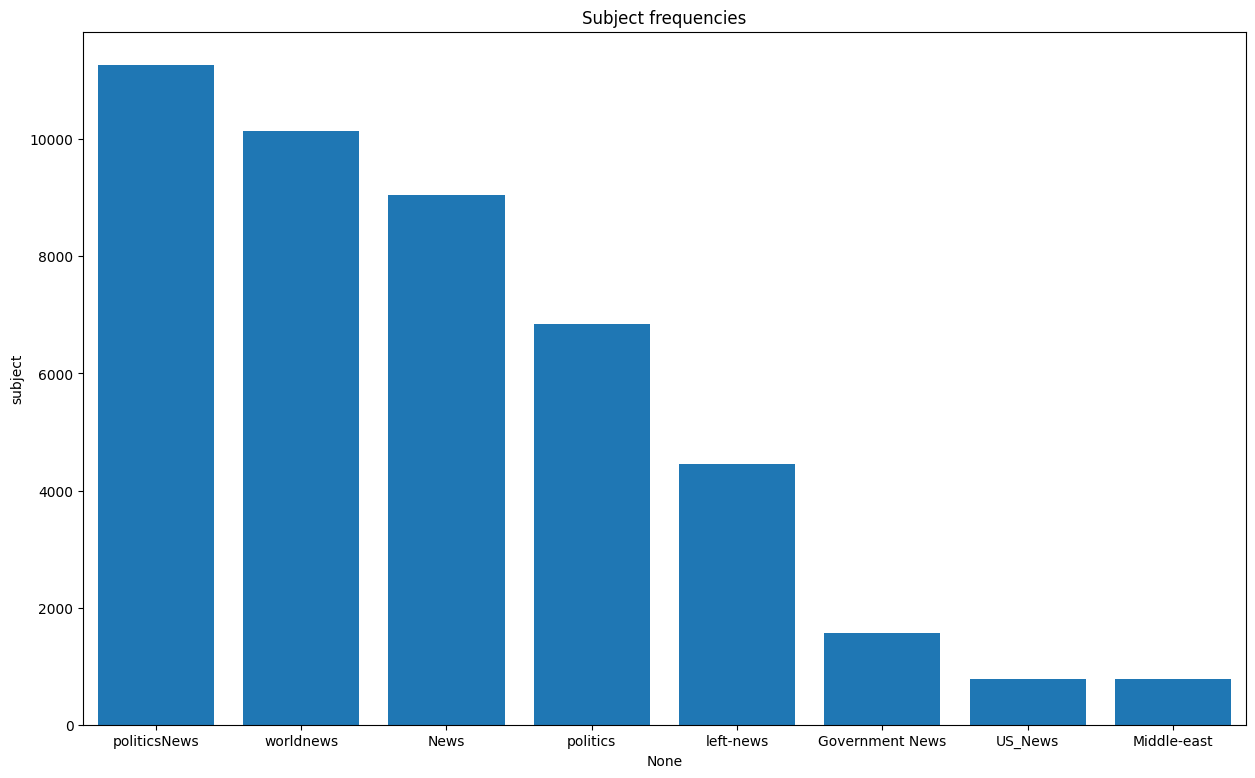

In [ ]:
plt.figure(figsize = [15, 9], clear = True, facecolor = 'white')
sns.barplot(x = news['subject'].value_counts().index,
            y = news['subject'].value_counts(),
            saturation = 1).set(title = "Subject frequencies")

In [ ]:
news.duplicated().sum()

209

In [ ]:
news.drop_duplicates(inplace = True)

In [ ]:
news.drop(['title', 'date', 'subject'], axis = 1, inplace = True)

In [ ]:
fake_text = ' '.join(news[news['class'] == 0]['text']) # Combine the text from the 'text' column of the news DataFrame into a single string.
words = nltk.word_tokenize(fake_text) # Tokenize the combined text into a list of words.
words = [word for word in words if word.isalpha()] # Filter out non-alphabetic words from the list.
stop_words = set(stopwords.words('english')) # Create a set of English stop words using NLTK.
words = [word.lower() for word in words if word.lower() not in stop_words] # Remove stop words from the list of words, and convert them to lowercase.
word_freq = Counter(words) # Count the frequency of each word.
most_common_words = word_freq.most_common(10) # Extract the 10 most common words and their frequencies.
for word, freq in most_common_words:
    print(f"{word}: {freq}")

trump: 74241
said: 31148
people: 26015
president: 25771
would: 23460
one: 22992
clinton: 18080
obama: 17920
like: 17659
donald: 17235


In [ ]:
real_text = ' '.join(news[news['class'] == 1]['text']) # Combine the text from the 'text' column of the news DataFrame into a single string.
words = nltk.word_tokenize(real_text) # Tokenize the combined text into a list of words.
words = [word for word in words if word.isalpha()] # Filter out non-alphabetic words from the list.
stop_words = set(stopwords.words('english')) # Create a set of English stop words using NLTK.
words = [word.lower() for word in words if word.lower() not in stop_words] # Remove stop words from the list of words, and convert them to lowercase.
word_freq = Counter(words) # Count the frequency of each word.
most_common_words = word_freq.most_common(10) # Extract the 10 most common words and their frequencies.
for word, freq in most_common_words:
    print(f"{word}: {freq}")

said: 97839
trump: 53639
would: 31168
reuters: 28118
president: 26107
state: 19525
government: 18007
new: 16625
house: 16365
states: 16278


In [ ]:
news.head()
print(news['text'].head())

0    WASHINGTON (Reuters) - The head of a conservat...
1    WASHINGTON (Reuters) - Transgender people will...
2    WASHINGTON (Reuters) - The special counsel inv...
3    WASHINGTON (Reuters) - Trump campaign adviser ...
4    SEATTLE/WASHINGTON (Reuters) - President Donal...
Name: text, dtype: object


In [ ]:
def clean_data(text):
    # Elimină "(Reuters)" și textul dinainte
    reuters_index = text.find("(Reuters)")
    if reuters_index != -1:
        text = text[reuters_index + len("(Reuters)"):]

    # Elimină semnele de punctuație
    no_punc = re.sub(r'[^\w\s]', '', text)

    # Lematizează textul
    lemmatizer = WordNetLemmatizer()
    lemmatized_text = ' '.join([lemmatizer.lemmatize(word) for word in no_punc.split()])

    # Elimină numerele
    text_no_numbers = ''.join([i for i in lemmatized_text if not i.isdigit()])

    # Convertește la litere mici și elimină link-urile
    text_lower_without_links = re.sub(r'http\S+', '', text_no_numbers.lower().strip())

    # Elimină stop words
    stop_words = set(stopwords.words('english'))
    text_without_stopwords = ' '.join([word for word in text_lower_without_links.split() if word not in stop_words])

    return text_without_stopwords

news['text'] = news['text'].apply(clean_data)

In [ ]:
news.head(n = 10).style.background_gradient(cmap = 'summer')

,text,class
0,head conservative republican faction us congress voted month huge expansion national debt pay tax cut called fiscal conservative sunday urged budget restraint keeping sharp pivot way among republicans us representative mark meadows speaking cbs face nation drew hard line federal spending lawmaker bracing battle january return holiday wednesday lawmaker begin trying pas federal budget fight likely linked issue immigration policy even november congressional election campaign approach republicans seek keep control congress president donald trump republicans want big budget increase military spending democrats also want proportional increase nondefense discretionary spending program support education scientific research infrastructure public health environmental protection trump administration ha already willing say going increase nondefense discretionary spending percent meadows chairman small influential house freedom caucus said program democrats saying thats enough need give government pay raise percent fiscal conservative dont see rationale eventually run people money said meadows wa among republicans voted late december party debtfinanced tax overhaul expected balloon federal budget deficit add trillion year trillion national debt interesting hear mark talk fiscal responsibility democratic us representative joseph crowley said cbs crowley said republican tax bill would require united states borrow trillion paid future generation finance tax cut corporation rich one least fiscally responsible bill weve ever seen passed history house representatives think going paying many many year come crowley said republicans insist tax package biggest us tax overhaul year boost economy job growth house speaker paul ryan also supported tax bill recently went meadows making clear radio interview welfare entitlement reform party often call would top republican priority republican parlance entitlement program mean food stamp housing assistance medicare medicaid health insurance elderly poor disabled well program created washington assist needy democrats seized ryans early december remark saying showed republicans would try pay tax overhaul seeking spending cut social program goal house republicans may take back seat senate vote democrats needed approve budget prevent government shutdown democrats use leverage senate republicans narrowly control defend discretionary nondefense program social spending tackling issue dreamers people brought illegally country child trump september put march expiration date deferred action childhood arrivals daca program protects young immigrant deportation provides work permit president ha said recent twitter message want funding proposed mexican border wall immigration law change exchange agreeing help dreamers representative debbie dingell told cbs favor linking issue policy objective wall funding need daca clean said wednesday trump aide meet congressional leader discus issue followed weekend strategy session trump republican leader jan white house said trump wa also scheduled meet sunday florida republican governor rick scott want emergency aid house ha passed billion aid package hurricane florida texas puerto rico wildfire california package far exceeded billion requested trump administration senate ha yet voted aid,1
1,transgender people allowed first time enlist us military starting monday ordered federal court pentagon said friday president donald trumps administration decided appeal ruling blocked transgender ban two federal appeal court one washington one virginia last week rejected administration request put hold order lower court judge requiring military begin accepting transgender recruit jan justice department official said administration challenge ruling department defense ha announced releasing independent study issue coming week rather litigate interim appeal occurs administration ha decided wait dods study continue defend president lawful authority district court meantime official s

##Data Preparation for LSTM

In [ ]:
x = news['text'] #variabila dependenta
y = news['class'] #variabila independenta

In [ ]:
# Tokenizarea
tokenizer = Tokenizer()
tokenizer.fit_on_texts(x)
# Calcularea dimensiunii vocabularului
vocab_size = len(tokenizer.word_index) + 1
# Transformarea textului în secvențe de indexuri numerice
x_sequences = tokenizer.texts_to_sequences(x)
#  Umplerea (padding) secvențelor cu zero-uri pentru a le uniformiza lungimea la 1000 de caractere
x_padded = pad_sequences(x_sequences, maxlen=1000)

In [ ]:
# Divizarea datelor în setul de antrenare și de testare
x_train, x_test, y_train, y_test = train_test_split(x_padded, y, test_size=0.3, random_state=42)

##Model

In [ ]:
# Construirea modelului LSTM
model = Sequential()
model.add(Embedding(input_dim=vocab_size, output_dim=30, input_length=1000))
model.add(LSTM(units=100))
model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 1000, 30)          6101040   
                                                                 
 lstm (LSTM)                 (None, 100)               52400     
                                                                 
 dense (Dense)               (None, 1)                 101       
                                                                 
Total params: 6153541 (23.47 MB)
Trainable params: 6153541 (23.47 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
model.fit(x_train, y_train, epochs=6, validation_data=(x_test, y_test))

Epoch 1/6
978/978 [==============================] - 174s 173ms/step - loss: 0.1548 - acc: 0.9411 - val_loss: 0.0648 - val_acc: 0.9801
Epoch 2/6
978/978 [==============================] - 94s 96ms/step - loss: 0.0793 - acc: 0.9739 - val_loss: 0.1549 - val_acc: 0.9379
Epoch 3/6
978/978 [==============================] - 72s 74ms/step - loss: 0.0309 - acc: 0.9906 - val_loss: 0.0786 - val_acc: 0.9742
Epoch 4/6
978/978 [==============================] - 64s 65ms/step - loss: 0.0123 - acc: 0.9967 - val_loss: 0.0840 - val_acc: 0.9734
Epoch 5/6
978/978 [==============================] - 54s 56ms/step - loss: 0.0038 - acc: 0.9991 - val_loss: 0.0770 - val_acc: 0.9811
Epoch 6/6
978/978 [==============================] - 51s 52ms/step - loss: 0.0041 - acc: 0.9990 - val_loss: 0.0811 - val_acc: 0.9804


In [ ]:
model.evaluate(x_test, y_test)

419/419 [==============================] - 6s 15ms/step - loss: 0.0811 - acc: 0.9804


[0.08112139254808426, 0.9803833961486816]

In [ ]:
y_pred = (model.predict(x_test) >= 0.5).astype(int)

419/419 [==============================] - 6s 13ms/step


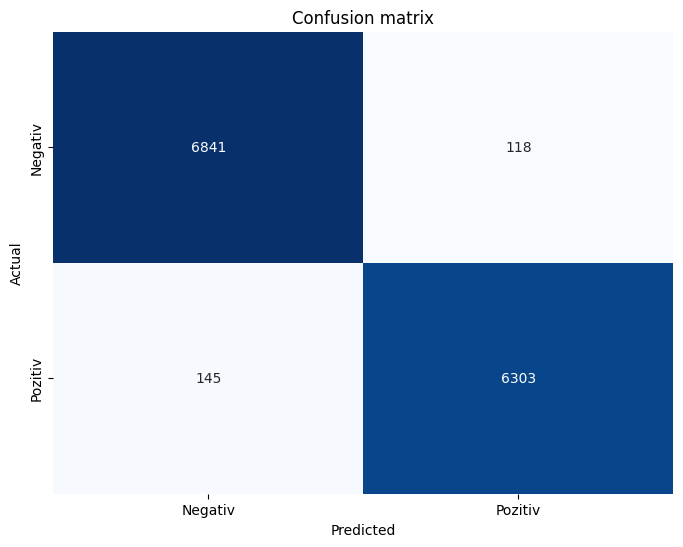

In [ ]:
conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['Negativ', 'Pozitiv'], yticklabels=['Negativ', 'Pozitiv'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion matrix')
plt.show()

In [ ]:
conf_matrix = confusion_matrix(y_test, y_pred)
print("Matricea de confuzie:")
print(conf_matrix)

Matricea de confuzie:
[[6841  118]
 [ 145 6303]]


##Test

In [ ]:
stire_falsa = ['In a story that stretches the bounds of belief, rumors are swirling that former U.S. President Donald Trump recently experienced a surreal encounter with extraterrestrial beings. Allegedly, Trump was abducted by aliens during a late-night golf outing at one of his luxurious resorts, leading to wild speculations about the nature of his interstellar adventure.']
stire_reala = [r'In September, Trump said that if re-elected president, he would resolve the war within 24 hours but declined to outline his peace plan. "If I tell you exactly, I lose all my bargaining chips. I mean, you can’t really say exactly what you’re going to do. But I would say certain things to Putin. I would say certain things to Zelenskiy," he said.']
stire = tokenizer.texts_to_sequences(stire_falsa)
stire = pad_sequences(stire, maxlen = 1000)
(model.predict(stire) >= 0.5).astype(int)

1/1 [==============================] - 0s 43ms/step


array([[0]])

----------------------------------------------------------------------------------------------------------------------------